# Imitation Learning - Real

This notebook outlines the work undertaken as part of the MSc Robotics Thesis at Cranfield University. The notebook constructs a context-adaptation model that can generalise between multiple viewing angles of a task, based on the work of: *Y. Liu et. Al, Learning to Imitate Behaviors from Raw Video
via Context Translation*

---
## Imports

This section imports all of the necessary libraries for the context-adaptation model.

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.io import gfile
import imageio
import pickle
import PIL
import PIL.Image as Image
import scipy.misc
import sys
import skvideo
import skvideo.io
from IPython.display import HTML
from tensorflow.python.framework import ops
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


---
## Loading Data

This section loads in the dataset that was constructed, resizing the videos to ensure they are consistent. A transformation is applied to the raw footage, to facilitate the performance of the model.

In [3]:
# Function to resize and transform images
def transform(image, resize_height=48, resize_width=48):
    cropped_image = np.array(Image.fromarray(image).resize((48, 48)))
    return np.array(cropped_image)/127.5 - 1

In [4]:
# Inverese transform of the image
def inverse_transform(images):
    return (images + 1.)/2.

---
The following section should only be run for the FIRST iteration. After this, the dataset should be loaded using the function below.

**Start of section**

In [32]:
# Loading in files
vids = gfile.glob("train/*.avi")

# Defining array to store data
idata = [[] for _ in range(80)]
# Initializing variable for number of failed attempts
nfail = 0
# Dimensions of the video
idim = (48, 48)
# Number of iterations
itr = 0
# Shuffling videos
np.random.shuffle(vids)

# Iterating through the list of videos
for name in vids:
    try:
        # Reading the video file
        vid = imageio.get_reader(name,  'ffmpeg')
        # Printing every 100 iterations
        if itr % 100 == 0:
            print(itr, map(len, idata))
        nlen = len(vid)
        print(itr)
        # Initializing/resetting array to store frames
        frames = []
        
        # Iterating through the frames of each video
        for j in range(80):
            # Extracting frames from video
            frame = transform(vid.get_data(j))
            # Appending frames to array
            frames.append(frame)
        for j, f in enumerate(frames):
            # Appending video to array
            idata[j].append(f)
        itr += 1
    except:
        nfail += 1
        # Printing error
        print("Unexpected error:", sys.exc_info())
        print(name)
        # Exiting if more than 10 fails occur
        if nfail > 10:
            break

Unexpected error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001F869588900>)
train\52.avi
Unexpected error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001F869588740>)
train\18.avi
Unexpected error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001F869588A00>)
train\107.avi
Unexpected error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001F869588E40>)
train\143.avi
Unexpected error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001F869588AC0>)
train\126.avi
Unexpected error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001F869588800>)
train\122.avi
Unexpected error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001F869588540>)
train\131.avi
Unexpected error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001F869588AC0>)
train\63.avi
Une

In [5]:
# Assigning data to a variable
vdata = np.array(idata)
vdata.shape

(80, 143, 48, 48, 3)

In [ ]:
# Saving transformed dataset
np.save('vdata_pushreal', vdata)

**End of section**

---

In [5]:
# Loading previous dataset (if you are loading the dataset in, as above, DO NOT RUN THIS CELL)
vdata = np.load('vdata_pushreal.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


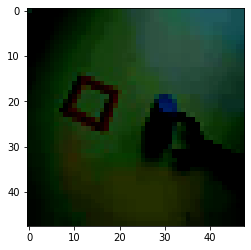

In [6]:
# Showing image to check loading
plt.imshow(vdata[0][50])

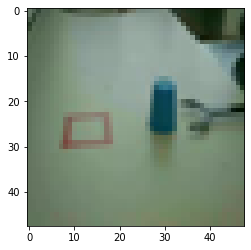

In [7]:
# Checking inverse transform works
plt.imshow(inverse_transform(vdata[0][2]))

---
## Model Building

This section defines the encoders, translation module and decoders for the context-translation archtiecture .

In [8]:
# Defining leaky ReLu
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [9]:
# Defining 2d convolution
def conv2d(input_, output_dim, 
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                  initializer=tf.truncated_normal_initializer(stddev=stddev))
        
        # Defining convolution parameters
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
    return conv

In [10]:
# Class for batch normalisation
class batch_norm(object):
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon  = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x):
        return tf.contrib.layers.batch_norm(x,
                      decay=self.momentum, 
                      updates_collections=None,
                      epsilon=self.epsilon,
                      scale=True,
                      is_training=tftrain,
                      scope=self.name)

In [11]:
# Function for linear activation
def linear(
    input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False
):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
              initializer=tf.constant_initializer(bias_start))
    if with_w:
        return tf.matmul(input_, matrix) + bias, matrix, bias
    else:
        return tf.matmul(input_, matrix) + bias

In [12]:
# Function for deconvolution 2D
def deconv2d(
    input_, output_shape,
    k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
    name="deconv2d", with_w=False
):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                  initializer=tf.random_normal_initializer(stddev=stddev))

        try:
            # Defining deconvolution
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv

In [13]:
# Class building overall model
class ContextAE:
    def __init__(
        self, gf_dim=48, df_dim=48,
        gfc_dim=100, dfc_dim=100,
        c_dim=3
    ):
        # Image dimensions (H)
        self.gf_dim = gf_dim
        # Image dimensions (W)
        self.df_dim = df_dim
        # Bandwidth (RGB, G, etc)
        self.c_dim = c_dim
        
        # Filter size
        self.gfc_dim = gfc_dim
        self.dfc_dim = dfc_dim

    
    # Building the model
    def build(self, image):
        # Finding shape of dataset
        imgshape = image.get_shape().as_list()
        print(imgshape)
        self.output_height, self.output_width = imgshape[-3:-1]
        # Defining batch size
        self.batch_size = imgshape[1]
        # Feature size
        featsize = 100
        # Defining source demonstration
        srcimg = image[0]
        # Defining target context image
        tgtimg = image[2]
        # Defining target video
        tgtctx = image[1]
        
        # Defining filter sizes
        nf0 = 32
        nf1 = 16
        nf2 = 16
        nf3 = 8
        # Defining stride sizes
        ns0 = 1
        ns1 = 2
        ns2 = 1
        ns3 = 2
        
        # Encoder function
        def encode(img):
            # Conv 1
            img_h0 = lrelu(conv2d(img, nf0, d_h=ns0, d_w=ns0, name='h0_conv'))
            # Conv 2
            img_h1 = lrelu(conv2d(img_h0, nf1, d_h=ns1, d_w=ns1, name='h1_conv'))
            # Conv 3
            img_h2 = lrelu(conv2d(img_h1, nf2, d_h=ns2, d_w=ns2, name='h2_conv'))
            # Conv 4
            img_h3 = lrelu(conv2d(img_h2, nf3, d_h=ns3, d_w=ns3, name='h3_conv'))
            print(img_h3.get_shape())
            # Linear Dropout, keep-probability 0.5
            img_h4 = lrelu(linear(tf.nn.dropout(tf.reshape(img_h3, [self.batch_size, -1]), keep_prob), featsize, 'h4_lin'))
            img_z = lrelu(linear(tf.nn.dropout(img_h4, keep_prob), featsize, 'hz_lin'))
            # Returning the encoded images
            return img_h0, img_h1, img_h2, img_h3, img_h4, img_z
        
        with tf.variable_scope("conv") as scope:
            # Encoding the source video
            srcimg_h0, srcimg_h1, srcimg_h2, srcimg_h3, srcimg_h4, srcimg_z = encode(srcimg)
            scope.reuse_variables()
            # Encoding the target
            tgtimg_h0, tgtimg_h1, tgtimg_h2, tgtimg_h3, tgtimg_h4, tgtimg_z = encode(tgtimg)
            tgtctx_h0, tgtctx_h1, tgtctx_h2, tgtctx_h3, tgtctx_h4, tgtctx_z = encode(tgtctx)

        with tf.variable_scope("translate") as scope:
            # Leaky ReLu activation, feature size 100
            trans_h0 = lrelu(linear(tf.nn.dropout(tf.concat([srcimg_z, tgtctx_z], 1), keep_prob), featsize, 'trans_h0'))
            trans_z = linear(tf.nn.dropout(trans_h0, keep_prob), featsize, 'trans_z')
            self.translated_z = trans_z
        
        # Stride values
        s_h, s_w = self.output_height, self.output_width
        s_h0, s_h1, s_h2, s_h3 = \
            int(s_h/ns0), int(s_h/ns0/ns1), int(s_h/ns0/ns1/ns2), int(s_h/ns0/ns1/ns2/ns3)
        s_w0, s_w1, s_w2, s_w3 = \
            int(s_w/ns0), int(s_w/ns0/ns1), int(s_w/ns0/ns1/ns2), int(s_w/ns0/ns1/ns2/ns3)
        
        
        # Decoder function
        def decode(z, skip_h3, skip_h2, skip_h1, skip_h0):
            # Leaky ReLu activation
            z_ = lrelu(linear(tf.nn.dropout(z, keep_prob), nf3*s_h3*s_w3, 'd_h0_lin'))
            # Dropout, keep-probability 0.5
            h0 = tf.nn.dropout(tf.reshape(z_, [-1, s_h3, s_w3, nf3]), keep_prob)
            # Layer 1
            h1 = lrelu(deconv2d(tf.concat([h0, skip_h3], 3),
                    [self.batch_size, s_h2, s_w2, nf2], name='d_h1', d_h=ns3, d_w=ns3))
            print(h1.get_shape())
            # Layer 2
            h2 = lrelu(deconv2d(tf.concat([h1, skip_h2], 3),
                    [self.batch_size, s_h1, s_w1, nf1], name='d_h2', d_h=ns2, d_w=ns2))
            print(h2.get_shape())
            # Layer 3
            h3 = lrelu(deconv2d(tf.concat([h2, skip_h1], 3),
                    [self.batch_size, s_h0, s_w0, nf0], name='d_h3', d_h=ns1, d_w=ns1))
            print(h3.get_shape())
            # Layer 4
            h4 = deconv2d(tf.concat([h3, skip_h0], 3),
                    [self.batch_size, s_h, s_w, self.c_dim], name='d_h4', d_h=ns0, d_w=ns0)
            print(h4.get_shape())
            # Returning decoded image
            return h4
        
        with tf.variable_scope("deconv") as scope:
            # Output of the model
            output_h4 = decode(trans_z, tgtctx_h3, tgtctx_h2, tgtctx_h1, tgtctx_h0)
            scope.reuse_variables()
            # True output from the demonstration
            truthoutput_h4 = decode(tgtimg_z, tgtctx_h3, tgtctx_h2, tgtctx_h1, tgtctx_h0)
        
        # Defining loss functions
        # Similarity loss
        self.simloss = tf.reduce_mean((trans_z - tgtimg_z) ** 2) * 1e3
        print(tgtimg_z.get_shape())
        self.out = output_h4
        self.out2 = truthoutput_h4
        print(self.out.get_shape())
        # Reconstruction loss 1
        self.recon1 = tf.nn.l2_loss(tgtimg - self.out)
        # Reconstruction loss 1
        self.recon2 = tf.nn.l2_loss(tgtimg - self.out2)
        # Overall loss
        self.loss = self.recon1 + self.recon2 + self.simloss

In [14]:
ops.reset_default_graph()
# Defining dimensions of image
idim = (48, 48)
# Defining keep probability
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
tftrain = tf.placeholder(tf.bool, name='tftrain')
# Defining batch size
batch_size = 100
# Defining input
tfinput = tf.placeholder(tf.float32, (3, batch_size) + idim + (3, ), name='x')
# Assigning class to instantiater
test = ContextAE()
# Building the model
test.build(tfinput)

[3, 100, 48, 48, 3]
(100, 12, 12, 8)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(100, 12, 12, 8)
(100, 12, 12, 8)
(100, 24, 24, 16)
(100, 24, 24, 16)
(100, 48, 48, 32)
(100, 48, 48, 3)
(100, 24, 24, 16)
(100, 24, 24, 16)
(100, 48, 48, 32)
(100, 48, 48, 3)
(100, 100)
(100, 48, 48, 3)


In [41]:
# Run with GPU
config = tf.ConfigProto(
     device_count = {'GPU': 0}
                       )
config.gpu_options.allow_growth=True
# Initializing session
sess = tf.Session(config=config)
# Defining learning rate
learning_rate = tf.placeholder(tf.float32, shape=[])
# Defining optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(test.loss)
# Running session
sess.run(tf.global_variables_initializer())
# Defining empty arrays for losses
allloss = []
validloss = []
itr = 0
# Defining parameter saver
saver = tf.train.Saver()

In [42]:
# Loading in old parameters, IF TRAINING HAS ALREADY BEEN COMPLETED ENSURE THIS CELL IS RUN IN LIEU OF THE TRAINING PROCESS
saver.restore(sess, './Models/ctxskiprealtransform127_11751')

INFO:tensorflow:Restoring parameters from ./Models/ctxskiprealtransform127_11751


In [43]:
# Optimizer for second encoder
optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(test.loss)
uninitialized_vars = []
# Initializing variables
for var in tf.global_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

init_new_vars_op = tf.variables_initializer(uninitialized_vars)
sess.run(init_new_vars_op)

---
## Training

This section outlines the training of the model from the constructed dataset. The cells in this section should only be run during training, after this point, provided the parameters have been loaded (see above), skip to the Validation section.

In [16]:
# Length of dataset
n = vdata.shape[1]
# Number of iterations
itr = 11751
# Length of data-samples (number of frames)
nlen = 80
# Number of training samples
ntrain = 122
# Number of validation samples
nvalid = n - ntrain
print(ntrain, nvalid)
# Validation data
validdata = vdata[:, ntrain:]
# Traning data
traindata = vdata[:, :ntrain]
print(validdata.shape, traindata.shape)

# Running with GPU
with tf.device('/device:GPU:0'):
    while True:
        # Source Video Index
        choicesrc = np.random.choice(ntrain, batch_size)
        # Target Video Index
        choicetgt = np.random.choice(ntrain, batch_size)
        # Source Video
        srcdata = traindata[np.arange(0, batch_size) % nlen, choicesrc]
        # Target Video
        tgtdata = traindata[np.arange(0, batch_size) % nlen, choicetgt]
        # Context Image
        tgtctx = traindata[0, choicetgt]
        # Data Batch
        batch = [srcdata, tgtctx, tgtdata]

        # Starting the training session, calculating losses
        _, loss, sim, r1, r2 = sess.run([optimizer, test.loss, test.simloss, test.recon1, test.recon2], 
                                        {tfinput: batch, learning_rate:1e-4, tftrain:False, keep_prob:0.5})
        
        # Printing results every 4 iterations
        if itr % 4 == 0:
            print(loss, sim, r1, r2)
            allloss = np.append(allloss, loss)
        
        # Validating every 40 iterations
        if itr % 40 == 0:
            choicesrc = np.random.choice(nvalid, batch_size)
            choicetgt = np.random.choice(nvalid, batch_size)
            srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
            tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
            tgtctx = validdata[0, choicetgt]
            batch = [srcdata, tgtctx, tgtdata]
            loss, sim, r1, r2 = sess.run([test.loss, test.simloss, test.recon1, test.recon2], 
                                         {tfinput: batch, tftrain:False, keep_prob:1.0})
            print(loss, sim, r1, r2,'E')
            validloss = np.append(validloss, loss)
        itr += 1
        
        if itr == 10000:
            break

122 21
(80, 21, 48, 48, 3) (80, 122, 48, 48, 3)
41518.805 2.2666834e-06 20759.402 20759.402
38597.383 4.9030785e-07 19298.691 19298.691 E
42389.72 2.2091888e-06 21194.86 21194.86
41466.074 2.1626386e-06 20733.037 20733.037
41514.52 2.1724306e-06 20757.26 20757.26
45403.336 2.3179668e-06 22701.668 22701.668
44007.547 2.3444397e-06 22003.773 22003.775
38448.08 1.8982242e-06 19224.04 19224.04
42174.027 2.0657378e-06 21087.014 21087.014
42946.51 1.8839064e-06 21473.256 21473.256
46563.65 2.279443e-06 23281.824 23281.826
45741.926 2.5919196e-06 22870.963 22870.963
36172.875 3.8326783e-07 18086.438 18086.438 E
43660.023 1.916776e-06 21830.012 21830.014
45969.883 2.1360638e-06 22984.941 22984.941
44517.6 2.272836e-06 22258.8 22258.8
46358.305 2.1105873e-06 23179.152 23179.152
41867.777 1.967619e-06 20933.889 20933.889
41192.105 1.8475179e-06 20596.053 20596.053
43829.445 2.1273872e-06 21914.723 21914.723
41490.484 1.9242302e-06 20745.242 20745.242
41493.64 1.9193064e-06 20746.82 20746.82
4204

KeyboardInterrupt: 

In [21]:
# Saving new parameters
saver.save(sess, 'ctxskiprealtransform127_'+str(itr))

'ctxskiprealtransform127_adadelta6360'

In [21]:
# Loading previous losses
validloss = np.load(f'Losses/ValidLoss11751.npy')
allloss = np.load(f'Losses/AllLoss11751.npy')
itr = 11751

In [ ]:
# Adding previous iteration data
validloss = np.append(validloss, validloss2)
allloss = np.append(allloss, allloss2)

In [ ]:
# Saving Loss data
np.save('ValidLoss'+str(itr), validloss_fix)
np.save('AllLoss'+str(itr), allloss_fix)

Text(0, 0.5, 'Total Loss')

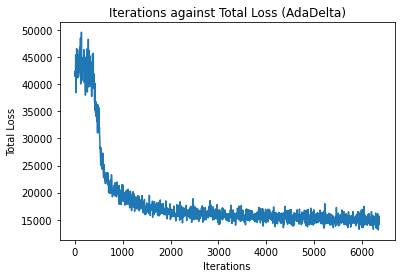

In [18]:
# Plotting total loss
plt.plot(np.linspace(0, itr, 1591), allloss[0:])
plt.title("Iterations against Total Loss")
plt.xlabel("Iterations")
plt.ylabel("Total Loss")

Text(0, 0.5, 'Total Loss')

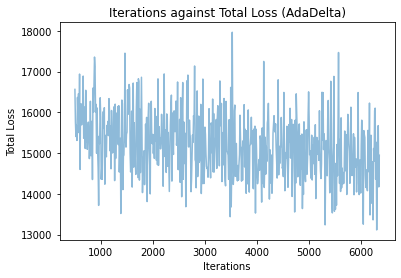

In [20]:
# Plotting total loss after 500 iterations
plt.plot(np.linspace(500, itr, 591), allloss[1000:], alpha=0.5)
plt.title("Iterations against Total Loss")
plt.xlabel("Iterations")
plt.ylabel("Total Loss")

Text(0, 0.5, 'Validation Loss')

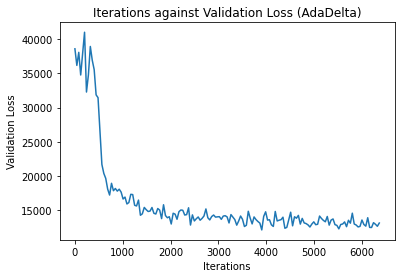

In [23]:
# Plotting validation loss
plt.plot(np.linspace(0, itr, 159), validloss[0:])
plt.title("Iterations against Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Validation Loss")

---
## Validating

This section outlines the validation that was done for the model after training. Once the model has been trained this section should be run. If the model has already been trained and the parameters have been restored, the following section should be run WITHOUT running the training section.

In [44]:
# Function to create gifs from decoder output
def savegif(name, frames):
    with imageio.get_writer(name, mode='I') as writer:
        for f in frames:
            writer.append_data((inverse_transform(f)*255).astype(np.uint8))

In [45]:
# Function to display gifs
def disimgs(imgs):
    strs = ''
    for img in imgs:
        strs += '<img src="%s?rand=%f" width="200px"/><br/>'%(img, np.random.rand())
    return HTML(strs)

In [46]:
# Function to resize images and apply inverse transform
def toint(frame):
    return scipy.misc.imresize((np.clip(inverse_transform(frame), 0, 1) * 255).astype(np.uint8), 
                          (frame.shape[0] * 10, frame.shape[1] * 10), interp='nearest')[:, :, ::-1]

In [21]:
# Length of dataset
n = vdata.shape[1]
# Number of iterations
itr = 11751
# Length of data-samples (number of frames)
nlen = 80
# Number of training samples
ntrain = 122
# Number of validation samples
nvalid = n - ntrain
print(ntrain, nvalid)
# Validation data
validdata = vdata[:, ntrain:]
# Traning data
traindata = vdata[:, :ntrain]

122 21


In [47]:
# Single test
nlen = 79
choicesrc = [0] * batch_size
choicetgt = [5] * batch_size
srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
tgtctx = validdata[0, choicetgt]
batch = [srcdata, tgtctx, tgtdata]

# Test 1
L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], 
                              {tfinput: batch, tftrain: False, keep_prob:1.0})


# Test 2
L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], 
                               {tfinput: batch, tftrain: False, keep_prob:1.0})


print(L, r1, r2)

# Saving the gif outputs
i = 4
i1 = "gif/__out%d.gif"%i
i2 = "gif/__out2_%d.gif"%i
i3 = "gif/__truth%d.gif"%i
savegif(i1, testouts[:nlen])
savegif(i2, testouts2[:nlen])
savegif(i3, tgtdata[:nlen])
imgs = [i1, i2, i3]
# Displaying constructed gifs
disimgs(imgs)

8110.518 4483.641 3616.536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2123.9136 1305.925 811.00806


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3009.6538 1840.7198 1161.4763


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3482.3252 1834.2401 1643.4683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2121.091 1290.7759 824.66534


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2584.661 1426.505 1154.6459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8252.503 4626.132 3616.536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3347.9297 1738.646 1605.0988


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5817.251 3145.7747 2666.5522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3265.6223 1747.0316 1515.5098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3814.5894 2058.397 1753.0957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3012.7268 1593.5752 1415.1285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4904.8125 3212.6912 1687.0266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3029.7603 1638.3005 1387.7932


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2198.4087 1162.8584 1031.649


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4687.8584 2779.659 1900.2372


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1970.9277 1064.5685 903.36676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3312.9941 1823.9523 1484.8694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2776.0266 1583.2595 1186.3745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8244.339 4357.712 3880.7249


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3429.6064 1872.4827 1552.907


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3091.2786 1638.3193 1448.7584


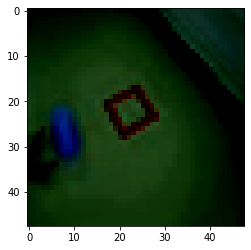

In [48]:
# Running model on entire validation dataset
imgs = []
for i in range(nvalid):
    choicesrc = [0] * batch_size
    choicetgt = [i] * batch_size
    srcdata = traindata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    
    # Test 1
    L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], 
                                  {tfinput: batch, tftrain: False, keep_prob:1.0})

    
    # Test 2
    L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], 
                                   {tfinput: batch, tftrain: False, keep_prob:1.0})

    # Printing the loss
    print(L, r1, r2)
    
    # Saving the gif outputs
    i1 = "gif/__out%d.gif"%i
    i2 = "gif/__out2_%d.gif"%i
    i3 = "gif/__truth%d.gif"%i
    plt.imshow(testouts[0])
    savegif(i1, testouts[:nlen])
    savegif(i2, testouts2[:nlen])
    savegif(i3, tgtdata[:nlen])
    imgs.extend([i1, i2, i3])
# Displaying the constructed gifs
disimgs(imgs)

13
20
27
34
41
48
55
62
69
76
83


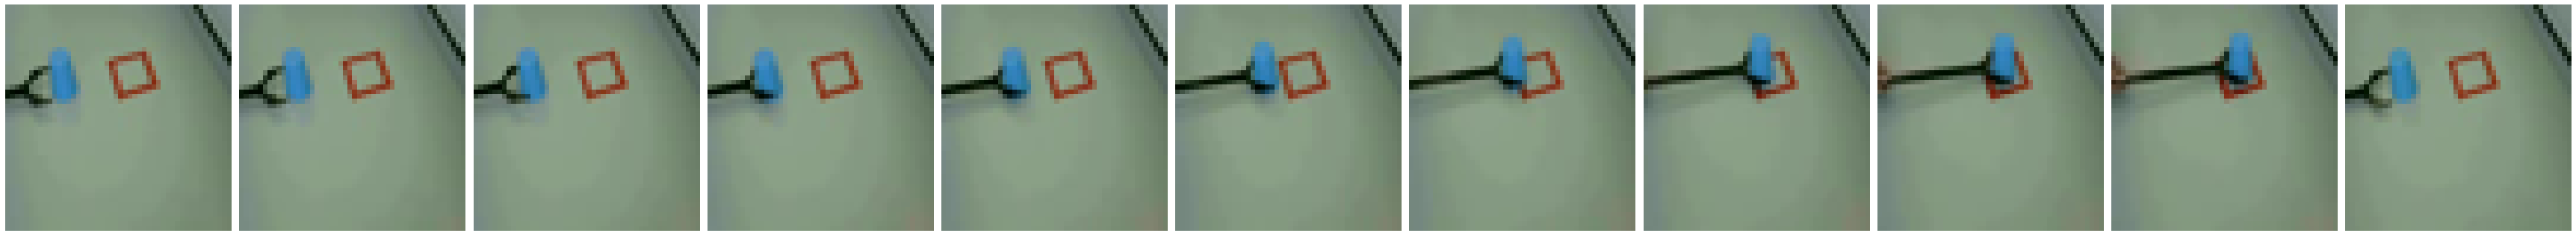

In [27]:
# Testing skip implementation
skip = 7
nlen = 80
fig, ax = plt.subplots(nrows=1, ncols=nlen//skip, figsize=(48,48))
for i in range(nlen//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(srcdata[i*skip + nlen - nlen//skip *(skip-1)-1]))
    print(i*skip + nlen - nlen//skip *(skip-1)-1)
    axx.axis('off')
plt.tight_layout()

13
20
27
34
41
48
55
62
69
76
83


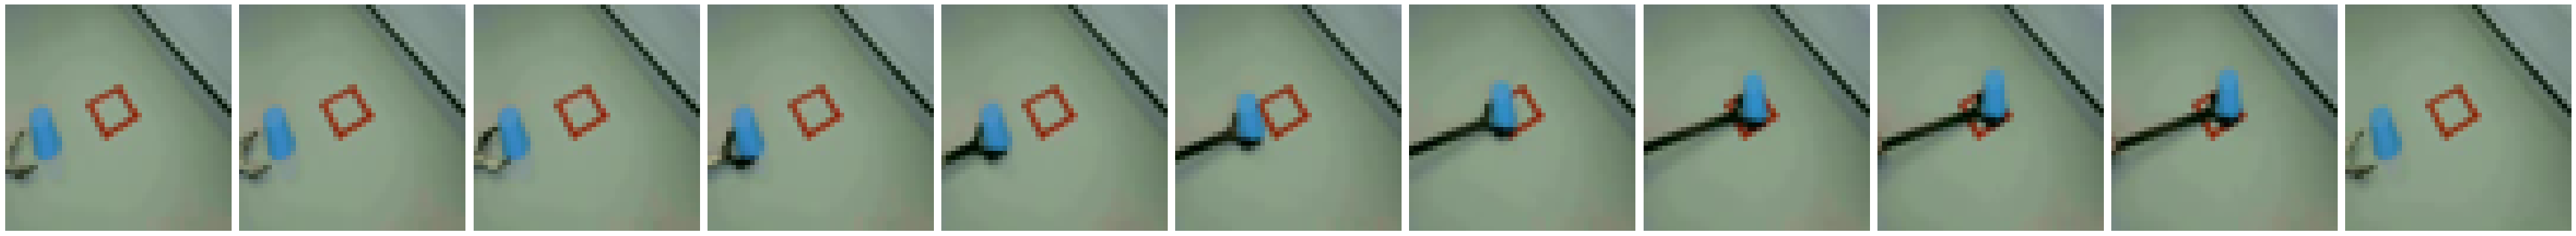

In [28]:
skip = 7
nlen = 80
fig, ax = plt.subplots(nrows=1, ncols=nlen//skip, figsize=(48,48))
for i in range(nlen//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(tgtdata[i*skip + nlen - nlen//skip *(skip-1)-1]))
    print(i*skip + nlen - nlen//skip *(skip-1)-1)
    axx.axis('off')
plt.tight_layout()

13
20
27
34
41
48
55
62
69
76
83


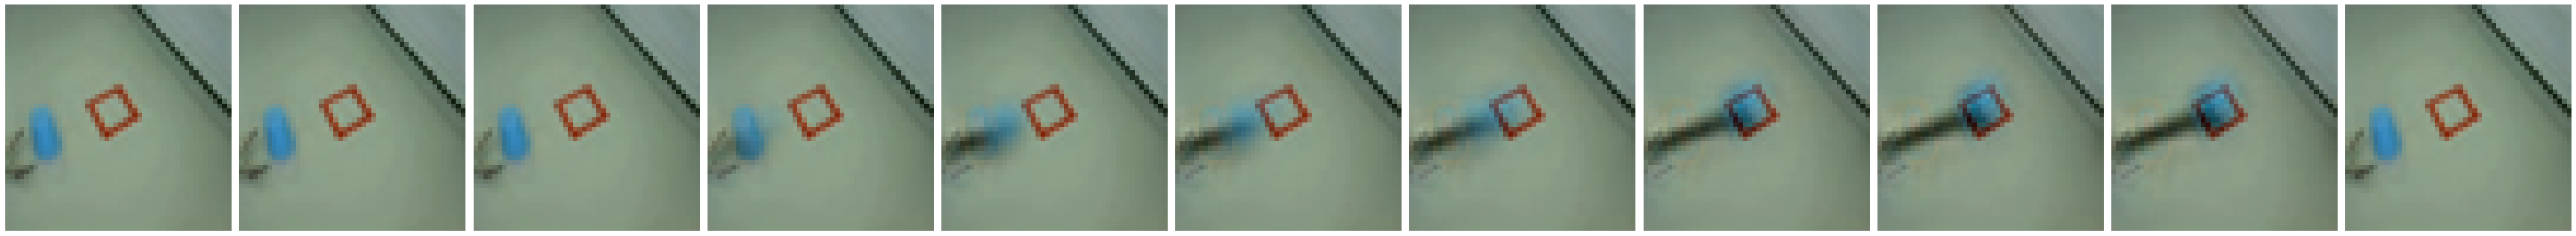

In [29]:
skip = 7
nlen = 80
fig, ax = plt.subplots(nrows=1, ncols=nlen//skip, figsize=(48,48))
for i in range(nlen//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(testouts[i*skip + nlen - nlen//skip *(skip-1)-1]))
    print(i*skip + nlen - nlen//skip *(skip-1)-1)
    axx.axis('off')
plt.tight_layout()

In [30]:
# Determining feature importance in training
feats = []
for i in range(nvalid):
    if i % 100 == 0:
        print(i)
    choicesrc = [i] * batch_size
    choicetgt = [1] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    feats.append(sess.run(test.translated_z, 
        {tftrain: False, tfinput: batch, keep_prob:1.0})[:nlen])
    
# Saving as np.array
tffeats = np.array(feats)
tffeats.shape

0


(21, 80, 100)

Text(0, 0.5, 'Feature weighting')

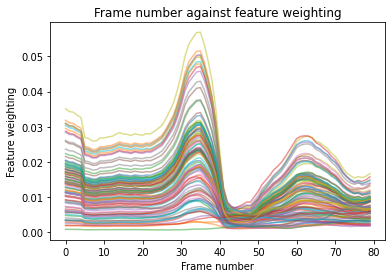

In [31]:
# Plotting frame number against feature weighting
plt.plot(np.std(tffeats, axis=0), alpha=0.5)
plt.title('Frame number against encoded feature weighting')
plt.xlabel('Frame number')
plt.ylabel('Feature weighting')

In [39]:
# Finding means of the 
means = np.mean(tffeats, axis=0)
means.shape

(80, 100)

Text(0, 0.5, 'Feature weighting')

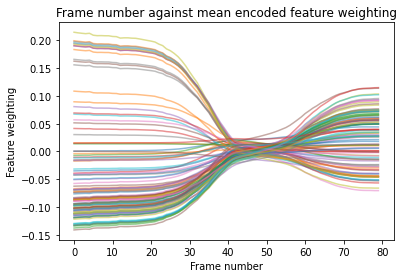

In [40]:
plt.plot(means, alpha=0.5)
plt.title('Frame number against mean encoded feature weighting')
plt.xlabel('Frame number')
plt.ylabel('Feature weighting')